# EDA
- First look on data
- Experiments and research
- Interactive cells
- Markdown comments
- Mistakes are not crusial
- No test submission

In [57]:
# Modules import
from importlib import reload

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import KFold
from sklearn import linear_model, metrics, preprocessing

# All special functions are written in support module
import support

# Settings
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 100)
sns.set(style="white")

In [58]:
reload(support)
print('Support Reloaded')

Support Reloaded


In [59]:
# Import data (we will immideatly merge some informaton together)
items              = pd.read_csv('./readonly/items.csv').set_index('item_id')
sales_train        = pd.read_csv('./readonly/sales_train.csv')
test               = pd.read_csv('./readonly/test.csv').join(items['item_category_id'], on='item_id').drop('ID', axis=1)
item_categories    = pd.read_csv('./readonly/item_categories.csv').set_index('item_category_id')
shops              = pd.read_csv('./readonly/shops.csv').set_index('shop_id')

assert not test['item_category_id'].isna().any()

In [60]:
# Checkpoint
data_origin = sales_train.copy()
test_origin = test.copy()

# -1. Overview

"date" is very important feature, but we won't look at it in this solution

In [61]:
sales_train.drop('date', axis=1, inplace=True)

Some shops have different IDs but equal names, let's fix this mistake

In [62]:
for pair in [(0, 57), (1, 58), (10, 11)]:
    sales_train.loc[(sales_train['shop_id'] == pair[0]), 'shop_id'] = pair[1]
    shops.drop(pair[0], inplace=True)

Check if all shops are open for the whole period

In [63]:
assert sales_train['shop_id'].nunique() == shops.shape[0]

In [64]:
for block in range(34):
    print(sales_train[sales_train['date_block_num'] == block]['shop_id'].nunique(), end=', ')

45, 46, 46, 46, 45, 46, 46, 45, 45, 46, 45, 46, 46, 46, 48, 49, 49, 49, 50, 51, 50, 52, 50, 50, 50, 47, 46, 47, 44, 43, 43, 42, 43, 44, 

Search for anything specific in test data

In [65]:
# to-do

# 0. NaNs

In [66]:
sales_train.isna().any()

date_block_num    False
shop_id           False
item_id           False
item_price        False
item_cnt_day      False
dtype: bool

# 1.Outliers
## 1.1 Every day sales
Lets consider what is hapenning with the value, which forms our target value. First idea is to watch a destribution plot and understand what happens with outliers.

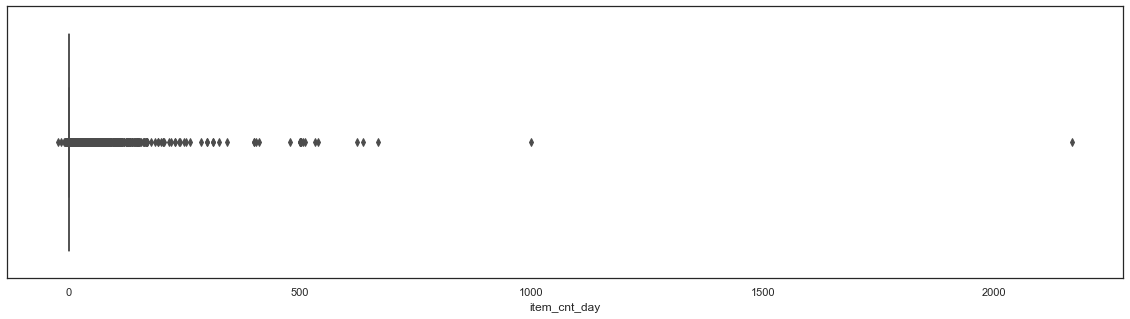

In [67]:
fig = plt.figure(figsize=(20, 5))
sns.boxplot(sales_train['item_cnt_day'])
plt.show()

In [68]:
sales_train[sales_train['item_cnt_day'] > 700]

,date_block_num,shop_id,item_id,item_price,item_cnt_day
2326930,24,12,20949,4.000000,1000.0
2909818,33,12,11373,0.908714,2169.0


In [69]:
items.loc[[11373, 20949]]['item_name']

item_id
11373                 Доставка до пункта выдачи (Boxberry)
20949    Фирменный пакет майка 1С Интерес белый (34*42)...
Name: item_name, dtype: object

In [70]:
sales_train[sales_train['item_id'] == 20949]['item_cnt_day'].mean(),\
    sales_train[sales_train['item_id'] == 11373]['item_cnt_day'].mean()

(5.987300574345884, 14.144396551724139)

So, both values are anomalies

In [71]:
sales_train = sales_train[sales_train['item_cnt_day'] <= 700]

According to the destribution there are sertain outliers. Let's dig into them and try to find any trends. We will separate whole dataset into 3 groups: negative values, "proper", "improper". ***nI*** (number of inclusions) is chosen as a parameter of separation by "item_cnt_day" as there are few unique values this column.

In [72]:
# Separate rows with negative values
negative_rows = sales_train[sales_train['item_cnt_day'] < 0]

# Check if some sertain shops have tendency for mistakes
print(len(negative_rows['shop_id'].unique()), "from", len(shops.index), "shops have mistakes with negative values")

for mistakes_threshold in [0.015, 0.01, 0.005]:
    many_mistakes = sales_train.groupby('shop_id').size().loc[
        negative_rows.groupby('shop_id').size() / sales_train.groupby('shop_id').size() > mistakes_threshold].index

    if (many_mistakes.size == 0):
        print("No shops have mistakes in more than", mistakes_threshold*100, "% of records")
    else:
        print("shops with ids", *many_mistakes, "have mistakes in more than", mistakes_threshold*100, "% of records")

54 from 57 shops have mistakes with negative values
No shops have mistakes in more than 1.5 % of records
shops with ids 12 have mistakes in more than 1.0 % of records
shops with ids 12 36 43 have mistakes in more than 0.5 % of records


Two possible solutions can be seen: include this negatives as values with the right sign or not to include them at all. Let's try the first approach.

In [73]:
# Apply "abs" function
sales_train.loc[:, 'item_cnt_day'] = sales_train['item_cnt_day'].apply(abs)

What about positive outliers?

In [74]:
# Let "counts" be a table in which every unique value of "item_cnt_day" column has a it's nI in data.
# Then let's take the i-th maximum nI and separate values of "count" table by this threshold.
# "proper_sales" dataframe will only include rows with "item_cnt_day" values, which nI is not less then threshold
i = 6

counts = sales_train['item_cnt_day'].value_counts().sort_values(ascending=False)
unique_counts_values = counts.unique()
threshold = unique_counts_values[min(i - 1, len(unique_counts_values) - 1)]

proper_values = counts[counts >= threshold].index
proper_sales = sales_train[sales_train['item_cnt_day'].isin(proper_values)]

improper_sales = sales_train.drop(proper_sales.index)

assert proper_sales.shape[0] + improper_sales.shape[0] == sales_train.shape[0], "Wrong sizes"

In [75]:
print("\"proper\" part of data consist of rows with values", *proper_sales['item_cnt_day'].sort_values().unique())

"proper" part of data consist of rows with values 1.0 2.0 3.0 4.0 5.0 6.0


In [76]:
topn = 10
print('From top', topn, 'items by inclusions in \"improper\" items meet in \"test\" part of data:')
for i in improper_sales['item_id'].value_counts().sort_values(ascending=False).index[:topn]:
    if i in test['item_id'].unique():
        print(i, ' (', improper_sales['item_id'].value_counts().sort_values(ascending=False)[i], ' inclusions) - ',
              item_categories.loc[items.loc[i]['item_category_id']]['item_category_name'], ' - ',
              items.loc[i]['item_name'],
              sep='')

From top 10 items by inclusions in "improper" items meet in "test" part of data:
20949 (7961 inclusions) - Подарки - Сумки, Альбомы, Коврики д/мыши - Фирменный пакет майка 1С Интерес белый (34*42) 45 мкм
2808 (338 inclusions) - Игры PC - Стандартные издания - Diablo III [PC, Jewel, русская версия]
3732 (310 inclusions) - Игры - PS3 - Grand Theft Auto V [PS3, русские субтитры]
11370 (257 inclusions) - Доставка товара - Доставка (по Москве)
3731 (226 inclusions) - Игры PC - Стандартные издания - Grand Theft Auto V [PC, русские субтитры]
3734 (212 inclusions) - Игры - XBOX 360 - Grand Theft Auto V [Xbox 360, русские субтитры]
3331 (181 inclusions) - Игры PC - Стандартные издания - FIFA 14 [PC, русская версия]
6675 (178 inclusions) - Игровые консоли - PS4 - Sony PlayStation 4 (500 Gb) Black (CUH-1008A/1108A/B01)


What can we see is the separation between products: games and 1C's special gifts are popular and can be bought many times per day. Let's see month's graphics of sales for some items to understand if there is a trend or games are bought many times only on release.

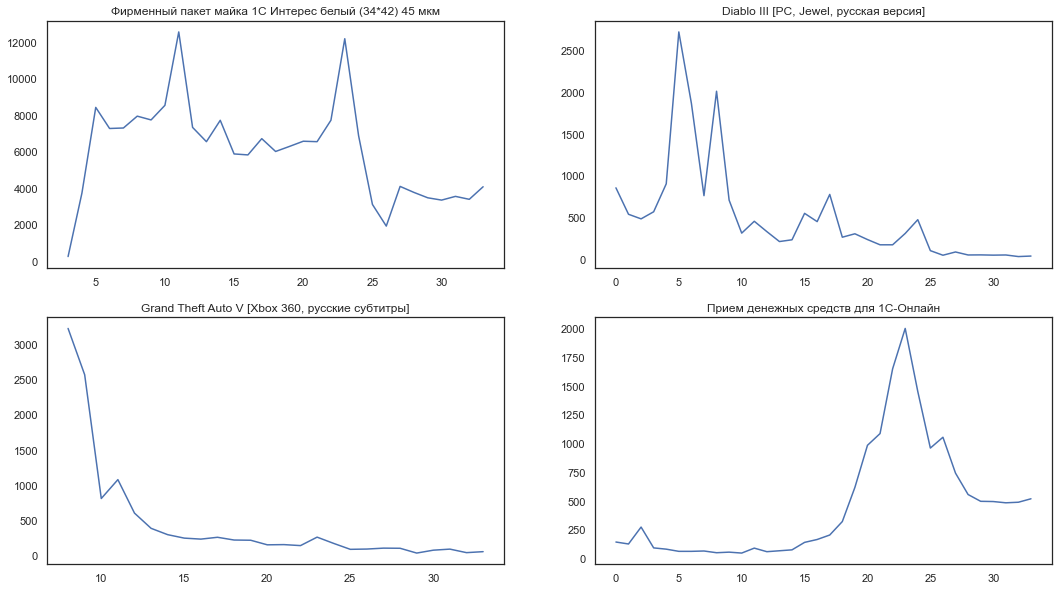

In [77]:
# Choose come interesting items
consider_items = [20949, 2808, 3734, 17717]

plt.subplots(len(consider_items) // 2, 2, figsize=(18, 5*len(consider_items) // 2))
subplot_id = 1

for item_id in consider_items:
    plt.subplot(len(consider_items) / 2, 2, subplot_id)
    subplot_id += 1
    plt.title(items.loc[item_id]['item_name'])
    plt.plot(sales_train[sales_train['item_id'] == item_id].groupby('date_block_num')['item_cnt_day'].sum())

As we can see, sales of games drop rapidly after release. Let's check if any new games are going to release in 34-th month.

In [78]:
# Let's find new games (index are found in "item_categories")
new_releases_categories = [19, 20, 23, 24, 29, 30]
test_items_not_met_in_train = test[test['item_id'].isin(sales_train['item_id'].unique()) == False]
print(len(test_items_not_met_in_train[test_items_not_met_in_train['item_category_id'].isin(new_releases_categories)]), 
      'rows in test will probably be big releases')

1722 rows in test will probably be big releases


**In conclusion**, \
1) we will include outliers to calculate "target" value \
2) our model must be robust to meeting with new items \
3) we should include more info about category, for example, how does "target" look on release \
4) story of an item must be included: how many month is it in sales and so on (we should also form our train data with this factor in mind)

## 1.2 Prices
First check is to find if prices change from time to time

In [79]:
support.has_changes_column(sales_train, ['date_block_num', 'shop_id', 'item_id'], 'item_price').value_counts()

False    2511461
True      424386
Name: has_changes, dtype: int64

Then let's take a look on destribution

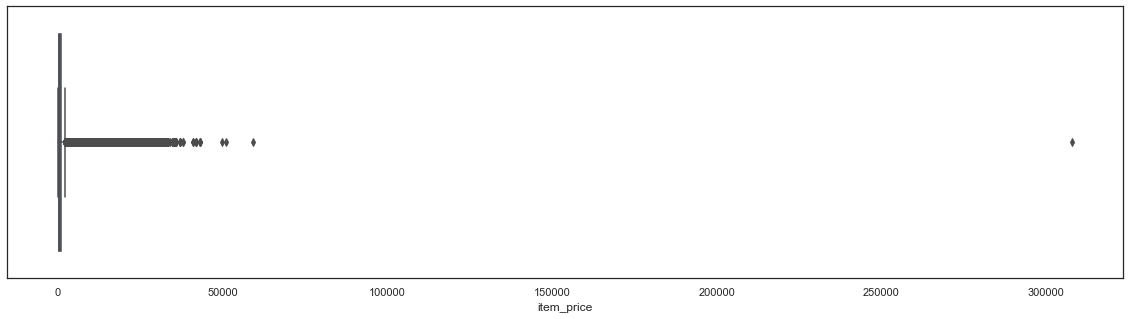

In [80]:
fig = plt.figure(figsize=(20, 5))
sns.boxplot(sales_train['item_price'])
plt.show()

We can't use the same reasoning as before, because it's usual that most of items are bought at a low price.

In [81]:
print(len(sales_train[sales_train['item_price'] <= 0]), "rows in data have negative values")

1 rows in data have negative values


In [82]:
sales_train[sales_train['item_price'] <= 0]

,date_block_num,shop_id,item_id,item_price,item_cnt_day
484683,4,32,2973,-1.0,1.0


In [83]:
items.loc[2973]

item_name           DmC Devil May Cry [PS3, русские субтитры]
item_category_id                                           19
Name: 2973, dtype: object

It is a game and as we already discussed this product has specific dinamic in sales, so let's drop it.

In [84]:
sales_train = sales_train[sales_train['item_price'] > 0]

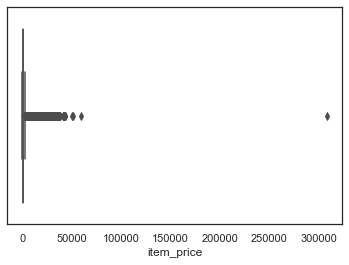

In [85]:
sns.boxplot(sales_train['item_price'])

In [92]:
whis = 1.5
IQR = sales_train['item_price'].quantile(0.75) - sales_train['item_price'].quantile(0.25)
outliers = sales_train[sales_train['item_price'] > sales_train['item_price'].quantile(0.75) + IQR*whis]

topn = 5
print("Top", topn, "items by price they were sold are:")
topn_outliers = outliers.sort_values('item_price', ascending=False)[:topn].join(
    items.drop('item_category_id', axis=1), on='item_id')[['item_id', 'item_price', 'item_name']]
topn_outliers

Top 5 items by price they were sold are:


,item_id,item_price,item_name
1163158,6066,307980.0,Radmin 3 - 522 лиц.
885138,11365,59200.0,Доставка (EMS)
1488135,13199,50999.0,Коллекционные шахматы (Властелин Колец)
2327159,7241,49782.0,UserGate Proxy & Firewall 6.X с модулем фильтр...
2910156,13403,42990.0,"Комплект ""Microsoft Xbox One 1TB Limited Edit..."


In [97]:
(outliers[outliers['item_price'] >= 45000]['item_id'].isin(test['item_id'].unique()) == False)

885138     False
1163158     True
1488135     True
2327159     True
Name: item_id, dtype: bool

In [94]:
(outliers['item_id'])

37          True
38          True
158         True
159         True
160        False
           ...  
2935782    False
2935802     True
2935804     True
2935813     True
2935822     True
Name: item_id, Length: 258942, dtype: bool

Let's dig just a bit in what is happening. For instance, Radmin 3 is a software for remote support, system administartion and so on and it is not an coincidence that 522 copies of it cost so much. It is an outlier. Let's drop such items which don't meet in "test" and have price more then sertain treshold. **Note**: we shouldn't do this in case of tree-based models, because they can use it properly.

In [102]:
outliers = outliers[(outliers['item_id'].isin(test['item_id'].unique()) == False) &
                   (outliers['item_price'] >= 45000)]

indexes = outliers.index
sales_train.drop(indexes, inplace=True)

# 2 Features
## 2.1 Additional data
Zero day sales will be very important as they can show the lack of demand.

In [31]:
# Save them for the further operations
item_mean_prices = sales_train.groupby('item_id')['item_price'].mean()
item_mean_prices.name = 'item_mean_prices'
shop_mean_prices = sales_train.groupby('shop_id')['item_price'].mean()
shop_mean_prices.name = 'shop_mean_prices'

In [32]:
# Gather random records with 0 sales
sample_size = 200

unique_shops = sales_train['shop_id'].unique()
unique_items = sales_train['item_id'].unique()
zeroes_addiction = []

for shop_id in unique_shops:
    for date_block_num in range(34):
        for item in np.random.choice(unique_items, sample_size, replace=False):
            zeroes_addiction.append([date_block_num, shop_id, 0, item, 0])

## 2.2 Sales' story
We should include information about previous sales and revenue (because prices are not constant).

In [33]:
# Checkpoint
sales_train_copy = sales_train.copy()

In [34]:
# We are going to add rows with zero "item_cnt_day"
sales_train = sales_train_copy.copy()

# Calculate revenue
sales_train = sales_train.append(pd.DataFrame(zeroes_addiction, columns=sales_train.columns))
sales_train['revenue'] = sales_train['item_price'] * sales_train['item_cnt_day']
sales_train.drop('item_price', axis=1, inplace=True)

# Sum up day sales for each month
train_groupped = sales_train.groupby(['date_block_num', 'shop_id', 'item_id'])[['item_cnt_day', 'revenue']].sum().reset_index()
train_groupped.rename(columns={'item_cnt_day': 'target'}, inplace=True)
train_groupped.loc[:, 'target'].clip(0, 20, inplace=True)

Let's mention, that it is essential to erase those date block, which we don't have history for. Of course, some of products can appear in the middle of dataset, but at least their story can show this fact.

In [35]:
# Attention: calculations may take some time
# Columns to be mentioned in story features
lag_columns = ['target', 'revenue']
nan_fill = {'target' : 0, 'revenue' : 0}

# Length of story of sales
story_len = 10

# Columns in respect to which further merges should be done
index_columns = ['date_block_num', 'shop_id', 'item_id']

# Cycle through length
for k in range(1, story_len + 1):
    gr_copy = train_groupped[lag_columns + index_columns].copy()
    
    # Merging is done with use of lagging previous records
    gr_copy.loc[:, 'date_block_num'] += k
    for column in lag_columns:
        gr_copy.rename(columns={column : column + '_lag_{}'.format(k)}, 
                      inplace=True)
        
    # Merge and deal fill NaNs
    train_groupped = pd.merge(train_groupped, gr_copy, on=index_columns, how='left')
    for column in lag_columns:
        train_groupped.fillna({column + '_lag_{}'.format(k) : nan_fill[column]}, inplace=True)
        
# As "date_block_num" starts with block 0, we have story records for all date blocks after "story_len"
train_groupped = train_groupped[train_groupped['date_block_num'] >= story_len]

In [36]:
# Check if there are any columns full of zeroes
assert not (train_groupped == 0).all().any()

# Add categories
train_groupped = train_groupped.join(items['item_category_id'], on='item_id')

## 2.2 Categorical data
Categories are very important, because they can give us an understanding of sales' behaviour during time. Some items can sell all the time without any fluctuations, others (like games) have most of sales in start. In this case these supervised and unsupervised methods are useful to encode information about categories as nominal data:\
1) One hot encoding \
2) Target mean encoding \
3) Frequency encoding 

In [37]:
# Checkpoint
train_save = train_groupped.copy()

In [38]:
category_columns = ['shop_id', 'item_id', 'item_category_id']

# There will be mistakes because of "join" usage if don't use checkpoint
train_groupped = train_save.copy()

# One Hot
train_groupped = train_groupped.join(pd.get_dummies(train_groupped['item_category_id'], prefix='category'))

# On validation another scheme should be used!
for category_column in category_columns:
    # Count mean values
    sample = train_groupped.groupby(category_column)[['target']].mean()
    sample.rename(columns={'target' : category_column + '_target_mean'}, inplace=True)
    
    # Mean encoding join
    train_groupped = train_groupped.join(sample[category_column + '_target_mean'], on=category_column)
    
    # Frequency encoding
    sample = train_groupped.groupby(category_column).size()/len(train_groupped)
    sample.name = category_column + '_freq'
    
    train_groupped = train_groupped.join(sample, on=category_column)

## 2.2 Numerical data

Let's include some polynoms to have a change of incresing power of models like Linear Regression

In [39]:
train_groupped.head()

,date_block_num,shop_id,item_id,target,revenue,target_lag_1,revenue_lag_1,target_lag_2,revenue_lag_2,target_lag_3,revenue_lag_3,target_lag_4,revenue_lag_4,target_lag_5,revenue_lag_5,target_lag_6,revenue_lag_6,target_lag_7,revenue_lag_7,target_lag_8,revenue_lag_8,target_lag_9,revenue_lag_9,target_lag_10,revenue_lag_10,item_category_id,category_2,category_3,category_4,category_5,category_6,category_7,category_8,category_9,category_11,category_12,category_13,category_14,category_15,category_16,category_17,category_18,category_19,category_20,category_21,category_22,category_23,category_24,category_25,category_26,...,category_39,category_40,category_41,category_42,category_43,category_44,category_45,category_46,category_47,category_48,category_49,category_50,category_51,category_53,category_54,category_55,category_56,category_57,category_58,category_59,category_60,category_61,category_62,category_63,category_64,category_65,category_66,category_67,category_68,category_69,category_70,category_71,category_72,category_73,category_74,category_75,category_76,category_77,category_78,category_79,category_80,category_81,category_82,category_83,shop_id_target_mean,shop_id_freq,item_id_target_mean,item_id_freq,item_category_id_target_mean,item_category_id_freq
570558,10,2,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.931683,0.010678,0.000731,0.001315,1.815973,0.184332
570559,10,2,33,2.0,398.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,499.0,37,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.931683,0.010678,1.372493,0.000335,1.507363,0.085626
570560,10,2,97,1.0,149.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.931683,0.010678,1.000000,0.000003,1.815973,0.184332
570561,10,2,482,2.0,6600.0,1.0,3300.0,2.0,6600.0,0.0,0.0,1.0,3300.0,2.0,6600.0,1.0,3300.0,1.0,3300.0,1.0,3300.0,1.0,3300.0,1.0,3300.0,73,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1.931683,0.010678,2.913580,0.000545,2.307651,0.003543
570562,10,2,791,1.0,600.0,2.0,1200.0,3.0,1800.0,1.0,600.0,1.0,600.0,3.0,1800.0,4.0,2400.0,2.0,1200.0,2.0,1200.0,1.0,600.0,2.0,1200.0,73,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1.931683,0.010678,1.892216,0.000160,2.307651,0.003543


To take maximum from sales' history lets count std of revenue and target, days with zero/non-zero incomes

In [40]:
train_groupped['revenue_std'] = train_groupped[['revenue_lag_{}'.format(i) for i in range(1, story_len + 1)]].std(axis=1)
train_groupped['target_std'] = train_groupped[['target_lag_{}'.format(i) for i in range(1, story_len + 1)]].std(axis=1)

train_groupped['zero_sales'] = (train_groupped[['revenue_lag_{}'.format(i) for i in range(1, story_len + 1)]] == 0).sum(axis=1)
train_groupped['nonzero_sales'] = story_len - train_groupped['zero_sales']

In [41]:
numerical_columns = ['revenue', 'shop_id_target_mean', 'shop_id_freq', 'item_id_target_mean',
                     'item_id_freq', 'item_category_id_target_mean', 'item_category_id_freq',
                     'target_lag_1', 'revenue_lag_1']
# Names of functions are presented in form of suffixes
functions = {
    '_square' : lambda x : x * x,
    '_sqrt'   : lambda x : -1 if (x < 0) else np.math.sqrt(x),
    '_cube'   : lambda x : x * x * x
}

for column in numerical_columns:
    for key in functions.keys():
        train_groupped[column + key] = train_groupped[column].apply(functions[key])

It is also important to include information about price, so let's join price's mean. **Note**: for the real validation this mean value should be taken from train dataset, not the full one.

In [42]:
train_groupped = train_groupped.join(item_mean_prices, on='item_id')
train_groupped = train_groupped.join(shop_mean_prices, on='shop_id')

We can also need to clear some values.

In [43]:
# "category_columns" consists of nominal values, so they are mostly useless for any model
train_groupped.drop(category_columns, axis=1, inplace=True)

# "revenue" is calculated with knowledge of target
train_groupped.drop('revenue', axis=1, inplace=True)

Let's conider the following format of data (conditions for the work of the code below): \
**Columns** : shop_id - item_id - item_category_id - item_price \
shop_id, item_id, item_category_id can't have NaNs \
item_price can have NaNs

# 3 Model
There is a list of models to try out in this task: \
1) sklearn.ensemble.RandomForestRegressor \
2) sklearn.linear_model.LinearRegression \
3) sklearn.linear_model.SGDRegressor \
4) sklearn.linear_model.Ridge \
5) lightgbm.LGBMRegressor \
6) xgboost.XGBRegressor

In [44]:
train_val = train_groupped[train_groupped['date_block_num'] <= 32]
test_val = train_groupped[train_groupped['date_block_num'] == 33]

In [45]:
X_train = train_val.drop('target', axis=1)
X_test = test_val.drop('target', axis=1)
y_train = train_val['target']
y_test = test_val['target']

In [46]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, SGDRegressor, Ridge
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

from sklearn.metrics import mean_squared_error as mse

In [47]:
lr = LinearRegression()
lr.fit(X_train, y_train)

mse(y_test, lr.predict(X_test))

3.1741069436159166

In [48]:
xgb = XGBRegressor(n_jobs=20, objective ='reg:squarederror', n_estimators=1000)
xgb.fit(X_train, y_train)

mse(y_test, xgb.predict(X_test))

c:\users\shepe\python\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
c:\users\shepe\python\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


0.2503631484617078

In [49]:
sgd = LinearRegression()
sgd.fit(X_train, y_train)

mse(y_test, sgd.predict(X_test))

3.1741069436159166

In [50]:
ridge = Ridge()
ridge.fit(X_train, y_train)

mse(y_test, ridge.predict(X_test))

c:\users\shepe\python\lib\site-packages\sklearn\linear_model\ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.81928e-42): result may not be accurate.
  overwrite_a=True).T


1.4666315790723274

In [51]:
lgbm = LGBMRegressor()
lgbm.fit(X_train, y_train)

mse(y_test, lgbm.predict(X_test))

0.2351093074054911

In [52]:
random_forest = RandomForestRegressor()
random_forest.fit(X_train, y_train)

mse(y_test, random_forest.predict(X_test))

c:\users\shepe\python\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.1896106116246676

**Conclusion**: because of the clip of target value tree-based models work better, so we can use them and combine answers using bagging/stacking